In [1]:
import os
from os.path import join
import random
from glob import glob
from PIL import Image
from datetime import datetime
import cv2
import numpy as np
from skimage import transform
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import monai
from segment_anything import sam_model_registry
from segment_anything.predictor import SamPredictor
from segment_anything.modeling import ImageEncoderViT, MaskDecoder, PromptEncoder
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

/root/autodl-tmp/sam/dpl/Inpaint-Anything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/root/autodl-tmp/sam/dpl/Inpaint-Anything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/root/autodl-tmp/sam/dpl/Inpaint-Anything/segment_anything/segment_anything/modeling/tiny_vit_sam.py:657: UserWarning: Overwriting tiny_vit_21m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registe

In [2]:

device='cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
torch.cuda.empty_cache()
model_path='./model/sam_vit_h_4b8939.pth'
sam_model=sam_model_registry['vit_h'](checkpoint=model_path).to(device)
predictor=SamPredictor(sam_model)

num2color={
    0:[0,0,0],
    1:[0, 153, 255],
    2:[102, 255, 153],
    3:[0, 204, 153],
    4:[255, 255, 102],
    5:[255, 255, 204],
    6:[255, 153, 0],
    7:[255, 102, 255],
    8:[102, 0, 51],
    9:[255, 204, 255],
    10:[255, 0, 102]
}
num2label={
    0:'background',
    1:'skin',
    2:'left eyebrow',
    3:'right eyebrow',
    4:'left eye',
    5:'right eye',
    6:'nose',
    7:'upper lip',
    8:'inner mouth',
    9:'lower lip',
    10:'hair'
}

In [3]:
class IG02DataSet(Dataset):
    
    def __init__(self,data_path,single=True):
        self.data_path=data_path
        self.data=sorted(glob(os.path.join(self.data_path,'*.image.png')))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        datapath=self.data[index]
        

In [26]:
class LaPaDataset(Dataset):
    def __init__(self,data_path,label_path):
        self.data_path=data_path
        self.label_path=label_path

        self.data=sorted(glob(os.path.join(self.data_path,'*.jpg')))
        self.label=sorted(glob(os.path.join(self.label_path,'*.png')))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data_path=self.data[index]
        label_path=self.label[index]
        img=Image.open(data_path)
        img=img.resize((1024,1024))
        img=np.array(img)
        
        label=Image.open(label_path)
        label=np.array(label)
        label_ids=np.unique(label)[1:]
        i=random.choice(label_ids.tolist())
        gt_mask=np.uint8(label==i)
        gt_mask=np.uint8(transform.resize(
            gt_mask,
            (1024,1024),
            order=0,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        ))
        gt_mask[gt_mask!=0]=1
        gt_mask[gt_mask!=1]=0
        label_list=[]
        # label=torch.tensor(label)
        center_list=[]
        bbox_list=[]
        
        # img=(img-img.min())/(img.max()-img.min())
        img=img.transpose((2,0,1))
        
            # if (gt_mask.any()==i)==False:
            #     center_list.append(None)
            #     bbox_list.append(None)
            #     continue
        y_idx,x_idx=np.where(gt_mask>0)
        y_min,y_max=np.min(y_idx),np.max(y_idx)
        x_min,x_max=np.min(x_idx),np.max(x_idx)
        dt_mask=cv2.distanceTransform(gt_mask[y_min:y_max+1,x_min:x_max+1],cv2.DIST_L2,3)
        local_coords=np.unravel_index(np.argmax(dt_mask,),dt_mask.shape)
        center_point=np.expand_dims(
            np.array([local_coords[1],local_coords[0]])+np.array([x_min,y_min]),axis=0)
        # label_list.append(gt_mask)
        # # label_list.append(torch.tensor(gt_mask))
        # center_list.append(center_point)
        # bbox_list.append(np.array([x_min,y_min,x_max,y_max]))
            
        img=torch.tensor(img).float()
        label_list=torch.tensor(gt_mask).long()
        center_list=torch.tensor(center_point).long()
        bbox_list=torch.tensor([x_min,y_min,x_max,y_max]).long()

        return (img,label_list,center_list,bbox_list)
    
train_lapa_set=LaPaDataset(data_path='./LaPa/train/images',label_path='./LaPa/train/labels')
train_lapa_loader=DataLoader(train_lapa_set,batch_size=2,shuffle=True)

In [ ]:
class finetuneSAM(nn.Module):
    def __init__(
            self,
            image_encoder:ImageEncoderViT,
            mask_decoder:MaskDecoder,
            prompt_encoder:PromptEncoder,

    ):
        super().__init__()
        self.image_encoder=image_encoder
        self.mask_decoder=mask_decoder
        self.prompt_encoder=prompt_encoder

        for param in self.image_encoder.parameters():
            param.requires_grad=False
        for param in self.prompt_encoder.parameters():
            param.requires_grad=False

    def forward(self,image:torch.Tensor,prompt:torch.Tensor,type:str):
        with torch.no_grad():
            image_embedding=self.image_encoder(image)
            if type=="single":
                label=torch.ones(size=prompt.shape[:-1],dtype=torch.long,device=prompt.device)
                sparse_embeddings,dense_embeddings=self.prompt_encoder(
                    points=(prompt,label),boxes=None,masks=None,
                )
            else:
                sparse_embeddings,dense_embeddings=self.prompt_encoder(
                    points=None,boxes=prompt,masks=None,
                )
        low_res_masks,_=self.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=self.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )
        ori_res_masks=F.interpolate(low_res_masks,size=(image.shape[2],image.shape[3]),mode='bilinear',
                                      align_corners=False,)
        return ori_res_masks

In [7]:
def train(model,dataloader,output_path='./res/finetune'
          ,data_path='./LaPa/train/images',label_path='./LaPa/train/labels'):
    os.makedirs(output_path, exist_ok=True)
    sam_model = model
    finetune_model = finetuneSAM(
        image_encoder=sam_model.image_encoder,
        mask_decoder=sam_model.mask_decoder,
        prompt_encoder=sam_model.prompt_encoder,
    ).to(device)
    finetune_model.train()

    optimizer=torch.optim.Adam(finetune_model.mask_decoder.parameters(),lr=1e-4,weight_decay=0.01)
    seg_loss=monai.losses.DiceLoss(sigmoid=True,squared_pred=True,reduction="mean")
    ce_loss=nn.BCEWithLogitsLoss(reduction='mean')

    num_epochs=10
    losses=[]
    best_loss=1e10

    for epoch in range(0,num_epochs):
        epoch_loss=0
        for step,(img,label_list,center_list,box_list) in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            loss1=0
            img=img.to(device)
            box=box_list.to(device)
            center_point=center_list.to(device)
            label=label_list[:,None,:].long().to(device)
            

            finetune_pred=finetune_model(img,center_point,'single')
            loss=seg_loss(finetune_pred,label)+ce_loss(finetune_pred,label.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss+=loss.item()
            loss1+=loss.item()
            finetune_pred=finetune_model(img,box,'box')
            loss=seg_loss(finetune_pred,label)+ce_loss(finetune_pred,label.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss+=loss.item()
            loss1+=loss.item()
            if (step+1)%100==0:
                
                print('batch loss:{:.4f}'.format(loss1))
                

        epoch_loss/=len(dataloader)*2
        losses.append(epoch_loss)
        print(
            f'Time: {datetime.now().strftime("%Y%m%d-%H%M")}, Epoch: {epoch}, Loss: {epoch_loss}'
        )
        checkpoint = {
            'model': finetune_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'loss': epoch_loss,
        }
        torch.save(checkpoint, join(output_path, 'finetune_latest.pth'))

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            checkpoint = {
                'model': finetune_model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'loss': epoch_loss,
            }
            torch.save(checkpoint, join(output_path, 'finetune_best.pth'))

        plt.plot(losses)
        plt.title("Dice + Cross Entropy Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
        plt.savefig(join(output_path,f'finetune_loss.png'))
        plt.close()

In [11]:
torch.cuda.empty_cache()
train(sam_model,dataloader=train_lapa_loader)

  0%|          | 1/9084 [00:02<5:39:50,  2.24s/it]

batch loss:0.9741939902305603


  1%|          | 61/9084 [02:16<5:36:39,  2.24s/it]

In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
torch.cuda.empty_cache()
model_path='./model/sam_vit_h_4b8939.pth'
model_path='./res/finetune/latest.pth'
sam_model=sam_model_registry['vit_h'](checkpoint=model_path).to(device)
predictor=SamPredictor(sam_model)

In [6]:
set=LaPaDataset(data_path='./LaPa/train/images',label_path='./LaPa/train/labels')
# loader=DataLoader(set,batch_size=2,shuffle=True)
# sam_model.eval()

In [43]:

for (img,label_list,center_list,box_list) in set:
    center_point=np.array(center_list)
    img=np.array(img)
    img=np.transpose(img,(1,2,0))
    img=(img*255).astype(np.uint8)
    # img=img[0].to(device)
    # label=label_list[:,None,:].long().to(device)
    # predictor.set_image(img)
    # pred,_,_=predictor.predict(center_point,np.array([1]),multimask_output=False)
    # plt.imshow(np.transpose(np.array(img),(1,2,0)))
    # print(label_list.shape)
    
    print(np.unique(label_list))
    
    plt.imshow(label_list)
    break

[0 1]
Error in callback <function flush_figures at 0x7f919f3fcaf0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
class LaPa_ValidDataset(Dataset):
    def __init__(self,data_path,label_path):
        self.data_path=data_path
        self.label_path=label_path

        self.data=sorted(glob(os.path.join(self.data_path,'*.jpg')))
        self.label=sorted(glob(os.path.join(self.label_path,'*.png')))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data_path=self.data[index]
        label_path=self.label[index]
        img=Image.open(data_path)
        img=img.resize((1024,1024))
        img=np.array(img)
        
        # img=torch.tensor(img,dtype=torch.float())
        label=Image.open(label_path)
        label=label.resize((1024,1024))
        label=np.array(label)
        label_list=[]
        # label=torch.tensor(label)
        center_list=[]
        bbox_list=[]
        label_ids = np.unique(label)[1:]
        i=random.choice(label_ids.tolist())
        img=(img-img.min())/(img.max()-img.min())
        img=img.transpose((2,0,1))
        gt_mask=np.uint8(label==i)
            # if (gt_mask.any()==i)==False:
            #     center_list.append(None)
            #     bbox_list.append(None)
            #     continue
        y_idx,x_idx=np.where(gt_mask>0)
        y_min,y_max=np.min(y_idx),np.max(y_idx)
        x_min,x_max=np.min(x_idx),np.max(x_idx)
        dt_mask=cv2.distanceTransform(gt_mask[y_min:y_max+1,x_min:x_max+1],cv2.DIST_L2,3)
        local_coords=np.unravel_index(np.argmax(dt_mask,),dt_mask.shape)
        center_point=np.expand_dims(
            np.array([local_coords[1],local_coords[0]])+np.array([x_min,y_min]),axis=0)
        # label_list.append(gt_mask)
        # # label_list.append(torch.tensor(gt_mask))
        # center_list.append(center_point)
        # bbox_list.append(np.array([x_min,y_min,x_max,y_max]))
            
        img=torch.tensor(img).float()
        label_list=torch.tensor(gt_mask).long()
        center_list=torch.tensor(center_point).long()
        bbox_list=torch.tensor([x_min,y_min,x_max,y_max]).long()

        return (img,label_list,center_list,bbox_list)
    
train_lapa_set=LaPaDataset(data_path='./LaPa/train/images',label_path='./LaPa/train/labels')
train_lapa_loader=DataLoader(train_lapa_set,batch_size=2,shuffle=True)

In [3]:
model_path='./res/finetune/best1.pth'
sam_model=sam_model_registry['vit_h'](checkpoint=model_path).to(device)
predictor=SamPredictor(sam_model)
set=LaPaDataset(data_path='./LaPa/train/images',label_path='./LaPa/train/labels')
# loader=DataLoader(set,batch_size=2,shuffle=True)
sam_model.eval()

for (img,label_list,center_list,box_list) in set:
    center_point=np.array(center_list)
    img=np.array(img)
    img=np.transpose(img,(1,2,0))
    img=(img*255).astype(np.uint8)
    # img=img[0].to(device)
    # label=label_list[:,None,:].long().to(device)
    predictor.set_image(img)
    pred,_,_=predictor.predict(center_point,np.array([1]),multimask_output=False)
    # plt.imshow(np.transpose(np.array(img),(1,2,0)))
    print(label_list)
    plt.imshow(pred[0])
    break


KeyboardInterrupt: 

In [94]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


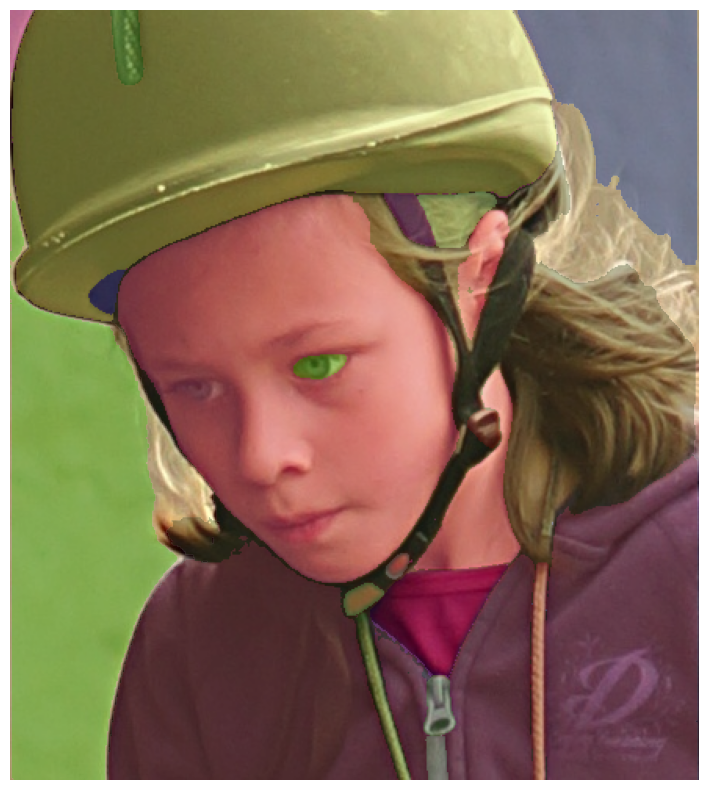

In [110]:
plt.figure(figsize=(10,10))
plt.imshow(imgs)
show_anns(mask)
plt.axis('off')
plt.show() 

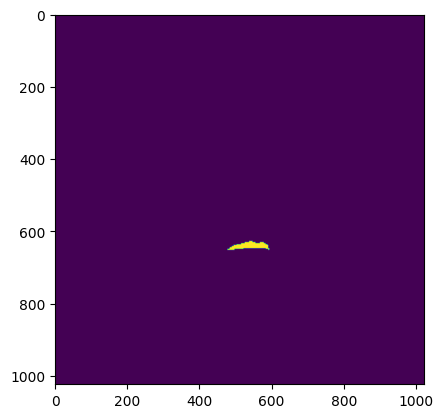

In [49]:
label=Image.open('./LaPa/val/labels/10004916254_0.png')
label=np.array(label)
label_id=np.unique(label)[1:]
id=random.choice(label_id.tolist())
gt_mask=np.uint8(label==id)
gt_mask
# y_idx,x_idx=np.where(gt_mask==1)
# y_min,y_max=np.min(y_idx),np.max(y_idx)
# x_min,x_max=np.min(x_idx),np.max(x_idx)
# x_max,x_min
gt_mask=np.uint8(transform.resize(
            gt_mask,
            (1024,1024),
            order=0,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        ))
plt.imshow(gt_mask)
gt_mask[gt_mask>0.3]=1
gt_mask[gt_mask!=1]=0

In [23]:
class ValidSet(Dataset):
    def __init__(self,data_path,label_path):
        self.data_path=data_path
        self.label_path=label_path

        self.data=sorted(glob(os.path.join(self.data_path,'*.jpg')))
        self.label=sorted(glob(os.path.join(self.label_path,'*.png')))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data_path=self.data[index]
        label_path=self.label[index]
        img=Image.open(data_path)
        img=np.array(img)
        label=Image.open(label_path)
        label=np.array(label)
        label_id=np.unique(label)[1:]
        # print(label_id)
        id=random.choice(label_id.tolist())
        gt_mask=np.uint8(label==id)
        # print(np.unique(gt_mask))
        y_idx,x_idx=np.where(gt_mask==1)
        y_min,y_max=np.min(y_idx),np.max(y_idx)
        x_min,x_max=np.min(x_idx),np.max(x_idx)
        dt_mask=cv2.distanceTransform(gt_mask[y_min:y_max+1,x_min:x_max+1],cv2.DIST_L2,3)
        local_coords=np.unravel_index(np.argmax(dt_mask,),dt_mask.shape)
        center_point=np.expand_dims(
            np.array([local_coords[1],local_coords[0]])+np.array([x_min,y_min]),axis=0)
            
        img=np.array(img)
        label_list=gt_mask
        center_list=center_point
        bbox_list=np.array([x_min,y_min,x_max,y_max])

        return (img,label_list,center_list,bbox_list,id)

In [30]:
def eval(model,img_path,label_path,origin=False):
    model.eval()
    model=SamPredictor(model)
    # model=model.to(device)
    validset=ValidSet(data_path=img_path,label_path=label_path)
    seg_list=[]
    gt_list=[]
    id_list=[]
    with torch.no_grad():
        for (img,label,center,box,id) in tqdm(validset):
            img=img.astype(np.uint8)
            model.set_image(img)
            seg,_,_=model.predict(point_coords=center,point_labels=np.array([1]),box=box,
                          multimask_output=False)
            seg_list.append(seg[0])
            gt_list.append(label)
            id_list.append(id)
            print(len(np.where(label>0)[0]),',',len(np.where(seg[0]>0)[0]))
            
    gt_dic={i:0 for i in range(11)}
    pred_dic={i:0 for i in range(11)}
    and_dic={i:0 for i in range(11)}
    for i in range(len(gt_list)):
        pred=seg_list[i]
        gt=gt_list[i]
        and_img=np.logical_and(pred,gt)
        id=id_list[i]
        pred_num=len(np.where(pred>0)[0])
        gt_num=len(np.where(gt>0)[0])
        and_num=len(np.where(and_img>0)[0])
        gt_dic[id]+=gt_num
        pred_dic[id]+=pred_num
        and_dic[id]+=and_num
        dice=0
        total=0
        for i in range(1,11):
            print(gt_dic[i])
            if gt_dic[i]==0:
                continue
            else:
                total+=1
                dice+=2*and_dic[i]/(pred_dic[i]+gt_dic[i])
        mdice=dice/total
        flag=os.path.exists('./res')
        if not flag:
            os.makedirs('./res')
        x_label=['skin','left eyebow','right eyebow','left eye','right eye','nose','upper lip',
                 'inner mouth','lower lip','hair']
        y_label=[2*and_dic[i]/(pred_dic[i]+gt_dic[i]) for i in range(1,11)]
        plt.bar(x=x_label,height=y_label)
        plt.xticks(rotation=45)
        for i in range(len(x_label)):
            plt.text(float(i),y_label[i],'%.2f'%y_label[i],ha='center',fontsize=8)
        if origin:
            plt.title(f'origin-{mdice}')
            plt.savefig(f'./res/origin.png')
        else:
            plt.title(f'train-{mdice}')
            plt.savefig(f'./res/train.png')
        
        return mdice

In [36]:
model_path='./res/finetune/best1.pth'
# model_path='./model/sam_vit_h_4b8939.pth'
# sam_model=torch.load(model_path)['model']
# torch.save(models,'./res/finetune/models_best.pth')
device='cuda'
sam_model=sam_model_registry['vit_h'](checkpoint=model_path).to(device)


In [37]:
eval(model=sam_model,img_path='./LaPa/val/images',label_path='./LaPa/val/labels',origin=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 1/2000 [00:00<08:25,  3.96it/s]

128 , 10


  0%|          | 2/2000 [00:00<08:28,  3.93it/s]

730 , 338


  0%|          | 3/2000 [00:00<08:31,  3.90it/s]

670 , 0


  0%|          | 4/2000 [00:01<08:33,  3.89it/s]

285 , 1


  0%|          | 5/2000 [00:01<08:55,  3.73it/s]

2312 , 780


  0%|          | 6/2000 [00:01<09:08,  3.64it/s]

1185 , 524


  0%|          | 7/2000 [00:01<08:58,  3.70it/s]

287 , 37


  0%|          | 8/2000 [00:02<08:58,  3.70it/s]

882 , 213


  0%|          | 9/2000 [00:02<08:49,  3.76it/s]

471 , 5


  0%|          | 10/2000 [00:02<08:54,  3.73it/s]

10639 , 5688


  1%|          | 11/2000 [00:02<08:48,  3.77it/s]

3 , 0


  1%|          | 12/2000 [00:03<08:42,  3.80it/s]

560 , 246


  1%|          | 13/2000 [00:03<08:41,  3.81it/s]

385 , 0


  1%|          | 14/2000 [00:03<09:10,  3.61it/s]

101944 , 147710


  1%|          | 15/2000 [00:04<09:03,  3.65it/s]

4077 , 730


  1%|          | 16/2000 [00:04<08:53,  3.72it/s]

338 , 0


  1%|          | 17/2000 [00:04<08:44,  3.78it/s]

242 , 0


  1%|          | 18/2000 [00:04<08:35,  3.84it/s]

88 , 4


  1%|          | 19/2000 [00:05<08:37,  3.83it/s]

2753 , 153


  1%|          | 20/2000 [00:05<08:31,  3.87it/s]

105 , 0


  1%|          | 21/2000 [00:05<08:32,  3.86it/s]

721 , 3


  1%|          | 22/2000 [00:05<08:32,  3.86it/s]

166 , 74


  1%|          | 23/2000 [00:06<08:30,  3.87it/s]

8943 , 16832


  1%|          | 24/2000 [00:06<08:29,  3.88it/s]

333 , 0


  1%|▏         | 25/2000 [00:06<08:31,  3.86it/s]

815 , 27


  1%|▏         | 26/2000 [00:06<08:38,  3.81it/s]

1519 , 1782


  1%|▏         | 27/2000 [00:07<08:36,  3.82it/s]

337 , 0


  1%|▏         | 28/2000 [00:07<08:49,  3.72it/s]

1070 , 0


  1%|▏         | 29/2000 [00:07<08:40,  3.79it/s]

33346 , 11482


  2%|▏         | 30/2000 [00:07<08:45,  3.75it/s]

1103 , 0


  2%|▏         | 31/2000 [00:08<08:38,  3.80it/s]

11 , 0


  2%|▏         | 32/2000 [00:08<08:35,  3.82it/s]

43388 , 18471


  2%|▏         | 33/2000 [00:08<08:54,  3.68it/s]

30496 , 20916


KeyboardInterrupt: 